In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
df=pd.read_csv('clothing_data_processed.csv')

In [3]:
# Scale rating feature to make its range between 1-5
df['rating'] = df['rating']/2

In [4]:
# Add new feature which has binary rating i.e either positive or negative 
# Categorise as 1 if rating is either 5 or 4 and rented item is not small or large in size
rating_to_binary = (df["rating"] == 5.0) | (df["rating"] == 4.0) | (df["rating"] == 3.0) & (df["fit"] == "fit")
rating_to_binary 
df["class_rating"] = np.where(rating_to_binary == True, 1, 0)
df["class_rating"]

0         1
1         1
2         1
3         1
4         1
         ..
192539    1
192540    1
192541    1
192542    1
192543    1
Name: class_rating, Length: 192544, dtype: int64

In [5]:
# Compressing records by considering the items which has more than 4 ratings and users who purchased more than 5 items
# Or give rating to more than 5 items


# including items with more than 4 ratings
itemRat_count = pd.DataFrame(df.groupby("item_id")["rating"].count())
itemRat_count = itemRat_count.loc[(itemRat_count["rating"] > 4)]
itemRat_count.reset_index(inplace=True)
#print('itemRat_count')
clothingRed = df[df["item_id"].isin(itemRat_count["item_id"])]
#print(clothingRed)

In [6]:
# including users with more than 4 purchases
userRat_count = pd.DataFrame(clothingRed.groupby("user_id")["rating"].count())
userRat_count = userRat_count.loc[(userRat_count.rating > 5)]
userRat_count.reset_index(inplace=True)
userRat_count.drop("rating", axis=1, inplace=True)
clothingRed = clothingRed[clothingRed["user_id"].isin(userRat_count["user_id"])]
clothingRed.reset_index(inplace=True, drop=True)

In [7]:
from sklearn.model_selection import train_test_split

# In train_test_split, user_id is stratified so same user id appears in the both the training and test test

clothing_train, clothing_test = train_test_split(clothingRed, stratify=clothingRed["user_id"],test_size=.2, random_state=1017)
print(clothing_train.shape)
print(clothing_test.shape)

(32277, 16)
(8070, 16)


In [8]:
clothing_test.groupby('user_id')['rating'].count().tail(50)

user_id
990235    3
990369    2
990405    2
990544    2
990625    1
990657    3
991099    3
991579    2
991702    3
991757    2
991902    1
991993    1
992004    1
992421    1
992560    1
992663    1
993019    1
993059    3
993344    1
993433    3
993618    1
993966    1
994205    1
994398    5
994448    2
994525    2
994767    1
994906    2
994907    3
995029    1
995412    5
995591    1
995826    8
995929    1
996183    2
996512    4
996592    1
997058    1
997189    2
997237    2
997360    3
998194    3
998267    1
998563    3
998780    1
998923    1
999183    2
999231    4
999274    1
999431    2
Name: rating, dtype: int64

# Content based  using TF-IDF

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Remove useless words 

stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swapnilshevate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Add new column which has  the text data such as category, review summary, review text
# Using this since in the dataset there is no meta data given for items
# Hence creating meta data extracting most of the text data from features 

df["item_review_text"] = (df["category"] + " " + df["review_summary"] + " " + df["review_text"]).str.lower()
df["item_review_text"] = df["item_review_text"].astype(str)
df["item_review_text"]= df["item_review_text"].apply(lambda x: " ".join([word for word in x.split() if word not in (stop_words)]))


In [11]:
df[["item_id", "item_review_text"]].tail()

,item_id,item_review_text
192539,2252812,jumpsuit love it!!! first item im thinking buy...
192540,682043,dress love it! pattern contrast dress really s...
192541,683251,"dress loud patterning, flattering fit like dvf..."
192542,126335,dress loved dress comfortable photographed ama...
192543,127865,gown wore beautiful black tie optional wedding...


In [12]:
agg_item_text = pd.DataFrame(df.groupby("item_id")["item_review_text"].sum())
agg_item_text.head()

,item_review_text
item_id,
123373,gown beautiful black tie wedding dress beautif...
123793,gown stunning gown. wore heart ball received c...
124204,"dress opened rtr box saw sequins, swear heart ..."
124553,dress lovely wedding guest dress loved dress. ...
125424,dress wore rehearsal dinner. classy. dress arr...


In [13]:
tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(agg_item_text["item_review_text"])
item_tfidf_similarity = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
item_tfidf_similarity_df = pd.DataFrame(item_tfidf_similarity, columns=agg_item_text.index, index=agg_item_text.index)

# Create item-item similarity matrix usig td-idf
item_tfidf_similarity_df.head()

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2960969,2961855,2962646,2963344,2963601,2963850,2964470,2965009,2965924,2966087
item_id,,,,,,,,,,,,,,,,,,,,,
123373,1.000000,0.919474,0.649086,0.686142,0.682330,0.920252,0.939419,0.683583,0.877012,0.687687,...,0.200619,0.038607,0.130307,0.117333,0.039596,0.134209,0.152569,0.060524,0.103376,0.170933
123793,0.919474,1.000000,0.714554,0.698996,0.691892,0.935052,0.934817,0.753782,0.888711,0.677578,...,0.184792,0.037345,0.134532,0.118775,0.031898,0.126343,0.135797,0.062329,0.095123,0.178313
124204,0.649086,0.714554,1.000000,0.852281,0.844130,0.653524,0.658194,0.930406,0.636755,0.866901,...,0.196257,0.035105,0.138120,0.144893,0.038250,0.130483,0.160751,0.063575,0.089675,0.127226
124553,0.686142,0.698996,0.852281,1.000000,0.923633,0.714095,0.690444,0.885807,0.668575,0.886473,...,0.240063,0.045744,0.158158,0.154093,0.058189,0.152267,0.185645,0.061639,0.114000,0.143828
125424,0.682330,0.691892,0.844130,0.923633,1.000000,0.678753,0.689418,0.876668,0.660464,0.875513,...,0.241325,0.049376,0.171950,0.152508,0.054272,0.151643,0.182971,0.061218,0.120915,0.140236


In [14]:
def evaluation(recommendations, user):
    # Get records of user from test data which has same user id as passed in the argument
    user_pref = clothing_test[clothing_test.user_id.isin([user])]
    #print(user_pref)
    # Get items from user test pref and check which items matches with calculated top 50 items using test data
    items_in_50 = user_pref[user_pref.item_id.isin(recommendations.item_id)]
    #print(items_in_50)
    
    # 'accuratelyCal_in50' is used for how many accurately calculated items out of top 50 similar ones 
    # Recall: (Total correctly predicted) / (total true positive + total false negative)
    recallCal = {"user_id": user,
                   "ratings_count": len(user_pref),
                   "accuratelyCal_in50": len(items_in_50[items_in_50.class_rating == 1]),
                   "recall_in50": len(items_in_50[items_in_50.class_rating == 1]) / len(user_pref)}
                    
    return recallCal
# evaluatio = pd.DataFrame()

In [16]:
def tfidf_contentRecSys(id):
    
    # Get record of user from train data which has same user id as passed in the argument
    top_train_user_item = clothing_train[clothing_train.user_id == id][:1]
    # print(top_train_user_item)
    # To get item id corresponding to above record
    top_train_user_item = int(top_train_user_item.item_id)
    # print(top_train_user_item)
    # To compute all the similar items corresponding to above record's item
    item_similarities = item_tfidf_similarity_df[[top_train_user_item]].sort_values([top_train_user_item], ascending=False)
    # print(item_similarities)
    # Take top 50 simialr items
    top_50 = item_similarities.iloc[1:51]
    # print(top_50)
    top_50.reset_index(inplace=True)
    # print(top_50)               
    return evaluation(recommendations = top_50, user = id)



test_user = 998563 
tfidf_contentRecSys(test_user)

{'user_id': 998563,
 'ratings_count': 3,
 'accuratelyCal_in50': 1,
 'recall_in50': 0.3333333333333333}

In [17]:
test_user = 991757
tfidf_contentRecSys(test_user)

{'user_id': 991757,
 'ratings_count': 2,
 'accuratelyCal_in50': 1,
 'recall_in50': 0.5}

# User based collaborative using Kmeans clustering

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

user_item_matx=clothing_train.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0, aggfunc='count')
print({'Shape:': user_item_matx.shape})

# Compute user-user similarity matrix using cosine 
user_rating_prox = cosine_similarity(user_item_matx, user_item_matx)

# Form clusters 
def k_select(k):
    rating_kmeans = KMeans(n_clusters = k, max_iter = 60, algorithm = "auto", n_init = 30, random_state = 1017).fit(user_rating_prox)
    ssd = {"cluster_n": k, "ssd": rating_kmeans.inertia_}
    return ssd

# Range of number of clusters
k_list=list(range(2,20))
kmean_ssd = pd.DataFrame([k_select(k) for k in k_list])



{'Shape:': (3822, 4447)}


Text(0.5, 1.0, 'Selecte k based on elbow shape')

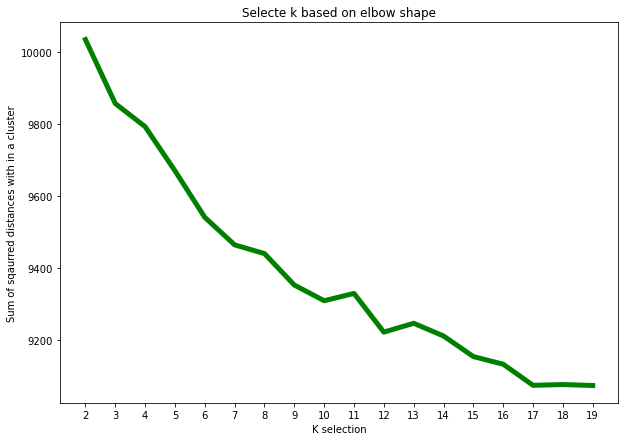

In [31]:
# Plot graph between number of clusters and ssd
plt.figure(figsize=(10, 7))
plt.plot(kmean_ssd["cluster_n"], kmean_ssd["ssd"], color="green", linewidth = 5)
plt.xticks(k_list, k_list)
plt.xlabel("K selection")
plt.ylabel("Sum of sqaurred distances with in a cluster")
plt.title("Selecte k based on elbow shape")

In [32]:
# By looking at graph based on the elbow,  k=9 seems good to select
rating_kmeans = KMeans(n_clusters = 15, max_iter = 60,  algorithm = "auto", n_init = 30, random_state = 1017).fit(user_rating_prox)
rating_kmeans

KMeans(max_iter=60, n_clusters=15, n_init=30, random_state=1017)

In [33]:
# Gives cluster number with corresponding user id
# Users in a specific cluster are similar
user_clusters = pd.DataFrame(rating_kmeans.labels_, columns=["cluster_n"])
user_clusters


,cluster_n
0,6
1,6
2,6
3,6
4,5
...,...
3817,6
3818,6
3819,6
3820,6


In [34]:
# Adding extra column consists label as cluster number 
user_item_matx["cluster"] = list(rating_kmeans.labels_)
user_item_matx[["cluster"]].head()


item_id,cluster
user_id,
657,6
1023,6
1089,6
1231,6
1434,5


In [35]:
# https://www.geeksforgeeks.org/python-pandas-melt/
cluster_items_melt = user_item_matx.melt(id_vars="cluster", value_name="rating")
cluster_items_melt = pd.DataFrame(cluster_items_melt.groupby(["cluster", "item_id"])["rating"].mean())
cluster_items_melt.reset_index(inplace=True)
cluster_items_melt


,cluster,item_id,rating
0,0,123373,0.000000
1,0,123793,0.001923
2,0,124204,0.000000
3,0,124553,0.000000
4,0,125424,0.007692
...,...,...,...
66700,14,2960969,0.000000
66701,14,2962646,0.000000
66702,14,2963344,0.000000
66703,14,2963850,0.000000


In [36]:
cluster_items_melt.sort_values(["cluster", "rating"], ascending=False, inplace=True)
cluster_items_melt.head()

,cluster,item_id,rating
64391,14,1378631,1.000000
62263,14,125465,0.083333
62283,14,135459,0.083333
63687,14,963476,0.083333
62259,14,123793,0.041667


In [37]:
user_item_matx_cp = user_item_matx.copy()
user_item_matx_cp.reset_index(inplace=True)


In [38]:
user_item_matx_cp

item_id,user_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,...,2958376,2958657,2959486,2960025,2960969,2962646,2963344,2963850,2966087,cluster
0,657,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,1089,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,1231,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,1434,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,998923,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3818,999183,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3819,999231,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3820,999274,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [39]:
def kMeansRec(uid):
    user_cluster = user_item_matx_cp[user_item_matx_cp.user_id == uid]
    user_cluster_ratings = cluster_items_melt[cluster_items_melt.cluster.isin(user_cluster.cluster)][:50]
                    
    return evaluation(recommendations = user_cluster_ratings, user = uid)

kMeansRec(998563)

{'user_id': 998563,
 'ratings_count': 3,
 'accuratelyCal_in50': 1,
 'recall_in50': 0.3333333333333333}

In [40]:
test_user = 991757
kMeansRec(991757)

{'user_id': 991757,
 'ratings_count': 2,
 'accuratelyCal_in50': 0,
 'recall_in50': 0.0}